In [16]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import jax

import arviz as az
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import BaseModel
from hbmep.model import functional as F
from hbmep.model.utils import Site as site

from models import RectifiedLogistic, Logistic5, Logistic4, ReLU
from utils import prepare_data

plt.rcParams['svg.fonttype'] = 'none'

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    format=FORMAT,
    level=logging.INFO,
    force=True
)


In [2]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/rats/J_RCML_000.toml"
config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/"
config.RESPONSE = ["Biceps", "ECR"]
config.MCMC_PARAMS["num_warmup"] = 6000
config.MCMC_PARAMS["num_samples"] = 4000

data_path = "/home/vishu/data/hbmep-processed/J_RCML_000/data.csv"
mat_path = "/home/vishu/data/hbmep-processed/J_RCML_000/mat.npy"

df, mat = prepare_data(config, data_path, mat_path)

2024-01-03 11:06:59,346 - hbmep.model.baseline - INFO - Initialized base_model


In [3]:
model = RectifiedLogistic(config=config)
df, encoder_dict = model.load(df=df)
model.plot(df=df, encoder_dict=encoder_dict)
mcmc, posterior_samples = model.run_inference(df=df)


2024-01-03 11:07:15,947 - hbmep.model.baseline - INFO - Initialized rectified_logistic
2024-01-03 11:07:15,948 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/
2024-01-03 11:07:15,948 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/
2024-01-03 11:07:15,949 - hbmep.dataset.core - INFO - Total non-positive observations: 0
2024-01-03 11:07:15,950 - hbmep.dataset.core - WARNING - Total missing observations: 0
2024-01-03 11:07:15,950 - hbmep.dataset.core - INFO - Processing data ...
2024-01-03 11:07:15,951 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2024-01-03 11:07:15,952 - hbmep.model.baseline - INFO - Rendering ...


2024-01-03 11:07:16,061 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/dataset.pdf
2024-01-03 11:07:16,062 - hbmep.utils.utils - INFO - func:plot took: 0.11 sec
2024-01-03 11:07:16,062 - hbmep.model.baseline - INFO - Running inference with rectified_logistic ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2024-01-03 11:07:57,440 - hbmep.utils.utils - INFO - func:run_inference took: 41.38 sec


In [4]:
prediction_df = model.make_prediction_dataset(df=df, num=1000)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2024-01-03 11:07:57,504 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec


2024-01-03 11:08:09,527 - hbmep.utils.utils - INFO - func:predict took: 12.02 sec
2024-01-03 11:08:09,527 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2024-01-03 11:08:10,292 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/recruitment_curves.pdf
2024-01-03 11:08:10,293 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.77 sec
2024-01-03 11:08:10,294 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2024-01-03 11:08:15,797 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/posterior_predictive_check.pdf
2024-01-03 11:08:15,799 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 5.50 sec
2024-01-03 11:08:15,799 - hbmep.utils.utils - INFO - func:render_predictive_check took: 5.51 sec


In [5]:
l5 = Logistic5(config=config)
df, encoder_dict = l5.load(df=df)
mcmc_l5, posterior_samples_l5 = l5.run_inference(df=df)
posterior_predictive_l5 = l5.predict(df=prediction_df, posterior_samples=posterior_samples_l5)
dest = os.path.join(model.build_dir, "l5_recruitment_curve.pdf")
l5.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples_l5, prediction_df=prediction_df, posterior_predictive=posterior_predictive_l5, destination_path=dest)
dest = os.path.join(model.build_dir, "l5_ppd.pdf")
l5.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive_l5, destination_path=dest)

l4 = Logistic4(config=config)
df, encoder_dict = l4.load(df=df)
mcmc_l4, posterior_samples_l4 = l4.run_inference(df=df)
posterior_predictive_l4 = l4.predict(df=prediction_df, posterior_samples=posterior_samples_l4)
dest = os.path.join(model.build_dir, "l4_recruitment_curve.pdf")
l4.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples_l4, prediction_df=prediction_df, posterior_predictive=posterior_predictive_l4, destination_path=dest)
dest = os.path.join(model.build_dir, "l4_ppd.pdf")
l4.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive_l4, destination_path=dest)


2024-01-03 11:08:50,696 - hbmep.model.baseline - INFO - Initialized logistic5
2024-01-03 11:08:50,696 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/
2024-01-03 11:08:50,733 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/
2024-01-03 11:08:50,734 - hbmep.dataset.core - INFO - Total non-positive observations: 0
2024-01-03 11:08:50,735 - hbmep.dataset.core - WARNING - Total missing observations: 0
2024-01-03 11:08:50,735 - hbmep.dataset.core - INFO - Processing data ...
2024-01-03 11:08:50,736 - hbmep.utils.utils - INFO - func:load took: 0.04 sec
2024-01-03 11:08:50,737 - hbmep.model.baseline - INFO - Running inference with logistic5 ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2024-01-03 11:09:06,154 - hbmep.utils.utils - INFO - func:run_inference took: 15.42 sec
2024-01-03 11:09:18,024 - hbmep.utils.utils - INFO - func:predict took: 11.87 sec
2024-01-03 11:09:18,025 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2024-01-03 11:09:18,770 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/l5_recruitment_curve.pdf
2024-01-03 11:09:18,771 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.75 sec
2024-01-03 11:09:18,771 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2024-01-03 11:09:24,351 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/l5_ppd.pdf
2024-01-03 11:09:24,352 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 5.58 sec
2024-01-03 11:09:24,352 - hbmep.utils.utils - INFO - func:render_predictive_check took: 5.58 sec
2024-01-03 11:09:24,353 - hbmep.model.baseline - INFO - Ini

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2024-01-03 11:09:35,629 - hbmep.utils.utils - INFO - func:run_inference took: 11.27 sec
2024-01-03 11:09:47,181 - hbmep.utils.utils - INFO - func:predict took: 11.55 sec
2024-01-03 11:09:47,182 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2024-01-03 11:09:47,913 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/l4_recruitment_curve.pdf
2024-01-03 11:09:47,913 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.73 sec
2024-01-03 11:09:47,914 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2024-01-03 11:09:53,489 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/l4_ppd.pdf
2024-01-03 11:09:53,490 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 5.58 sec
2024-01-03 11:09:53,490 - hbmep.utils.utils - INFO - func:render_predictive_check took: 5.58 sec


In [17]:
relu = ReLU(config=config)
df, encoder_dict = relu.load(df=df)
mcmc_relu, posterior_samples_relu = relu.run_inference(df=df)
posterior_predictive_relu = relu.predict(df=prediction_df, posterior_samples=posterior_samples_relu)
dest = os.path.join(model.build_dir, "relu_recruitment_curve.pdf")
relu.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples_relu, prediction_df=prediction_df, posterior_predictive=posterior_predictive_relu, destination_path=dest)
dest = os.path.join(model.build_dir, "relu_ppd.pdf")
relu.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive_relu, destination_path=dest)


2024-01-03 11:21:59,346 - hbmep.model.baseline - INFO - Initialized relu
2024-01-03 11:21:59,346 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/
2024-01-03 11:21:59,347 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/
2024-01-03 11:21:59,347 - hbmep.dataset.core - INFO - Total non-positive observations: 0
2024-01-03 11:21:59,348 - hbmep.dataset.core - WARNING - Total missing observations: 0
2024-01-03 11:21:59,348 - hbmep.dataset.core - INFO - Processing data ...
2024-01-03 11:21:59,349 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2024-01-03 11:21:59,349 - hbmep.model.baseline - INFO - Running inference with relu ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2024-01-03 11:22:11,896 - hbmep.utils.utils - INFO - func:run_inference took: 12.55 sec
2024-01-03 11:22:23,287 - hbmep.utils.utils - INFO - func:predict took: 11.39 sec
2024-01-03 11:22:23,287 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2024-01-03 11:22:24,095 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/relu_recruitment_curve.pdf
2024-01-03 11:22:24,096 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.81 sec
2024-01-03 11:22:24,096 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2024-01-03 11:22:29,724 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/1_Introduction/relu_ppd.pdf
2024-01-03 11:22:29,725 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 5.63 sec
2024-01-03 11:22:29,726 - hbmep.utils.utils - INFO - func:render_predictive_check took: 5.63 sec


In [6]:
time_const = 1000
obs = np.array(posterior_predictive[site.obs]) * time_const
obs_map = obs.mean(axis=0)
obs_hpdi = hpdi(obs, prob=.95)

a, b, v, L, ell, H = \
    posterior_samples[site.a], \
    posterior_samples[site.b], \
    posterior_samples[site.v], \
    posterior_samples[site.L], \
    posterior_samples[site.ell], \
    posterior_samples[site.H]

features, intensity,= model._collect_regressor(df=prediction_df)
features, n_features = features
intensity, n_data = intensity
intensity = intensity.reshape(-1, 1)
intensity = np.tile(intensity, (1, model.n_response))

feature0 = features[0].reshape(-1,)
feature1 = features[1].reshape(-1,)

params = [a, b, v, L, ell, H]
params = [u[:, feature0, feature1] for u in params]

fn_out = F.rectified_logistic(intensity, *tuple(params))
fn_out = np.array(fn_out)

fn_prime_out = F.prime(F.rectified_logistic, np.tile(intensity, (params[0].shape[0], 1, 1)), *tuple(params))
fn_prime_out = np.array(fn_prime_out) * time_const
fn_prime_out.shape

a_map = a.mean(axis=0)
obs_map = obs.mean(axis=0)


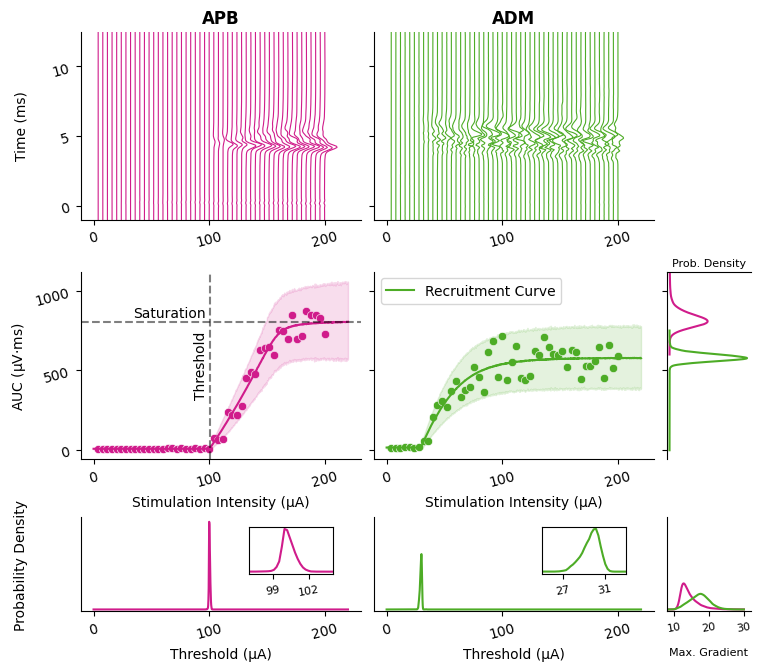

In [22]:
scatter_alpha = 1

a_, b_ = model.mep_window
time = np.linspace(a_, b_, mat.shape[1])
colors = [(0.6510, 0.3804, 0.1020), (0.2055, 0., 0.4000)]
colors = [(0.8157, 0.1098, 0.5451), (0.3020, 0.6745, 0.1490)]
const = [200, 100]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / const[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * time_const, color=colors[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * time_const)
    ax.set_ylim(bottom=-0.001 * time_const, top=(model.mep_size_window[1] + (model.mep_size_window[0] - (-0.001))) * time_const)

    ax = axes[1, muscle_ind]
    sns.lineplot(x=prediction_df[model.intensity], y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color=colors[muscle_ind], alpha=1, label="Recruitment Curve")
    sns.scatterplot(x=df[model.intensity], y=df[model.response[muscle_ind]] * time_const, color=colors[muscle_ind], alpha=1, ax=ax)
    ax.fill_between(
        prediction_df[model.intensity],
        obs_hpdi[0, ..., muscle_ind],
        obs_hpdi[1, ..., muscle_ind],
        color=colors[muscle_ind],
        alpha=.15
    )
    if ax == axes[1, 0]:
        ax.axvline(x=a_map[0, 0, muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, 0, muscle_ind] - 1, obs_map.max(axis=0)[muscle_ind] - 60, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, 0, muscle_ind] - 35, obs_map.max(axis=0)[muscle_ind] + 10, "Saturation", va="bottom", ha="center")

    ax = axes[2, muscle_ind]
    samples = a[:, 0, 0, muscle_ind]
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    # x_grid = np.linspace(samples.mean() - 20, samples.mean() + 20, 1000)
    density = kde(x_grid)
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ax, color=colors[muscle_ind])
    ax.plot(x_grid, density, color=colors[muscle_ind])
    ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    ins.plot(x_grid, density, color=colors[muscle_ind])
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ins, color=colors[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")
    if muscle_ind == 0:
        ins.set_xticks([99, 102])
        ins.set_xlim(left=97, right=104)
    if muscle_ind == 1:
        ins.set_xticks([27, 31])
        ins.set_xlim(left=25, right=33)
    ins.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=8,
        labelrotation=10
    )

    ax = axes[1, 2]
    # ax.axhline(obs.mean(axis=0).max(axis=0)[muscle_ind], color="black", linestyle="--")
    if muscle_ind == 0:
        samples = (H[:, 0, 0, muscle_ind] * time_const) + 30
        x_grid = np.linspace(600, obs_hpdi.max() + 100, 5000)

    if muscle_ind == 1:
        samples = H[:, 0, 0, muscle_ind] * time_const + 20
        x_grid = np.linspace(0, 750, 5000)

    kde = stats.gaussian_kde(samples)
    # x_grid = np.linspace(0, obs_hpdi.max() + 30, 5000)
    density = kde(x_grid)
    ax.plot(density, x_grid, color=colors[muscle_ind])
    # sns.kdeplot(y=H[:, 0, 0, muscle_ind] * time_const + 30, ax=ax, color=colors[muscle_ind])

    ax = axes[2, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    samples = max_grad
    kde = stats.gaussian_kde(samples)
    x_grid = np.linspace(8, 30, 1000)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=colors[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 1:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 2:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=10,
            labelsize=8
        )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
    )


axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])

axes[0, 0].set_xticks([0, 100, 200])
axes[0, 0].set_yticks([0, 5, 10])
axes[1, 0].set_yticks([0, 500, 1000])
# axes[1, 0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

axes[1, 1].legend(loc="upper left")
if axes[1, 0].get_legend():
    axes[1, 0].get_legend().set_visible(False)

axis_label_size = 10
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$ms)", size=axis_label_size)

axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)

axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])
axes[2, 1].sharey(axes[2, 0])
axes[2, 0].set_ylim(bottom=-0.018)
axes[2, 0].set_ylabel("Probability Density")
# axes[2, 0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

axes[2, 0].set_xlabel("Threshold (µA)", size=axis_label_size)
axes[2, 1].set_xlabel("Threshold (µA)", size=axis_label_size)

axes[2, 2].sharey(axes[2, 0])
axes[2, 2].set_xlim(left=8, right=32)
axes[2, 2].set_xticks([10, 20, 30])
axes[2, 2].set_xlabel("Max. Gradient", size=8)

ax = axes[0, 2]
sides = ['left', 'top', 'bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
)

ax = axes[1, 2]
sides = ['bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    labelrotation=10,
    labelsize=8
)
ax.set_xlabel("Prob. Density", size=8)
axes[1, 2].sharey(axes[1, 0])
# axes[1, 2].set_xlabel("Prob. Density", size=8)
axes[1, 2].xaxis.set_label_position('top')
# axes[1, 2].set_ylabel("Saturation (µV$\cdot$ms)", size=8)
axes[1, 2].set_xlim(left=-0.0006)
axes[1, 2].set_ylim(top=1000 + 120)

axes[1, 2].set_xticks([0, 0.015/2, 0.015])
# axes[1, 2].set_xticklabels([0.0, 0.1, 0.2])
# axes[1, 2].set_ylabel("Saturation (µA)", size=8)

axes[0, 0].set_title("APB", fontweight="bold")
axes[0, 1].set_title("ADM", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(model.build_dir, "01b.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "01b.png")
fig.savefig(dest, dpi=600)


In [18]:
obs_l5 = np.array(posterior_predictive_l5[site.obs]) * time_const
obs_l4 = np.array(posterior_predictive_l4[site.obs]) * time_const
obs_relu = np.array(posterior_predictive_relu[site.obs]) * time_const


In [28]:
a_l4 = posterior_samples_l4[site.a]
a_l4.shape

(16000, 1, 1, 2)

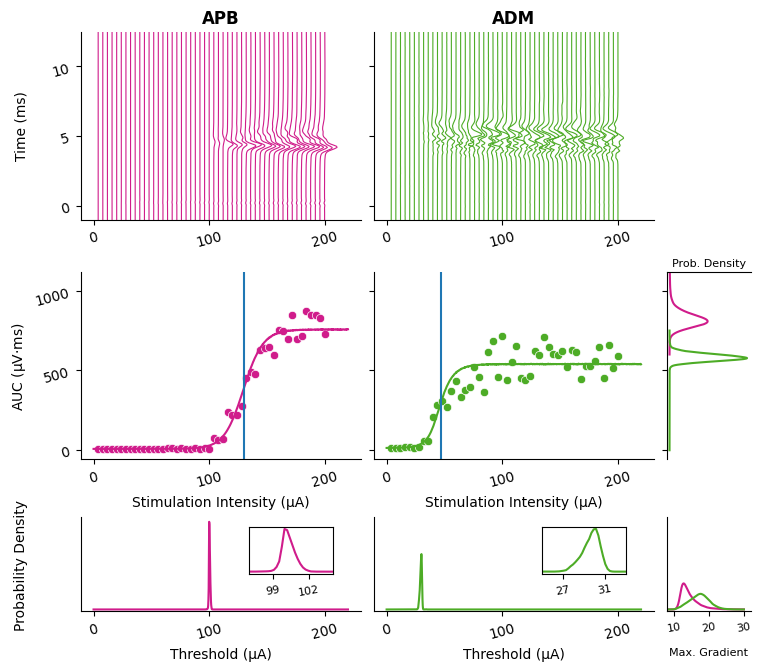

In [29]:
scatter_alpha = 1

a_, b_ = model.mep_window
time = np.linspace(a_, b_, mat.shape[1])
colors = [(0.6510, 0.3804, 0.1020), (0.2055, 0., 0.4000)]
colors = [(0.8157, 0.1098, 0.5451), (0.3020, 0.6745, 0.1490)]
const = [200, 100]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / const[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * time_const, color=colors[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * time_const)
    ax.set_ylim(bottom=-0.001 * time_const, top=(model.mep_size_window[1] + (model.mep_size_window[0] - (-0.001))) * time_const)

    ax = axes[1, muscle_ind]
    # sns.lineplot(x=prediction_df[model.intensity], y=obs_l5.mean(axis=0)[..., muscle_ind], ax=ax, color="grey", alpha=1)
    sns.lineplot(x=prediction_df[model.intensity], y=obs_l4.mean(axis=0)[..., muscle_ind], ax=ax, color=colors[muscle_ind], alpha=1)
    ax.axvline(a_l4[:, 0, 0, muscle_ind].mean())
    # sns.lineplot(x=prediction_df[model.intensity], y=obs_relu.mean(axis=0)[..., muscle_ind], ax=ax, color=colors[muscle_ind], alpha=1)
    sns.scatterplot(x=df[model.intensity], y=df[model.response[muscle_ind]] * time_const, color=colors[muscle_ind], alpha=1, ax=ax)

    ax = axes[2, muscle_ind]
    samples = a[:, 0, 0, muscle_ind]
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    # x_grid = np.linspace(samples.mean() - 20, samples.mean() + 20, 1000)
    density = kde(x_grid)
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ax, color=colors[muscle_ind])
    ax.plot(x_grid, density, color=colors[muscle_ind])
    ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    ins.plot(x_grid, density, color=colors[muscle_ind])
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ins, color=colors[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")
    if muscle_ind == 0:
        ins.set_xticks([99, 102])
        ins.set_xlim(left=97, right=104)
    if muscle_ind == 1:
        ins.set_xticks([27, 31])
        ins.set_xlim(left=25, right=33)
    ins.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=8,
        labelrotation=10
    )

    ax = axes[1, 2]
    # ax.axhline(obs.mean(axis=0).max(axis=0)[muscle_ind], color="black", linestyle="--")
    if muscle_ind == 0:
        samples = (H[:, 0, 0, muscle_ind] * time_const) + 30
        x_grid = np.linspace(600, obs_hpdi.max() + 100, 5000)

    if muscle_ind == 1:
        samples = H[:, 0, 0, muscle_ind] * time_const + 20
        x_grid = np.linspace(0, 750, 5000)

    kde = stats.gaussian_kde(samples)
    # x_grid = np.linspace(0, obs_hpdi.max() + 30, 5000)
    density = kde(x_grid)
    ax.plot(density, x_grid, color=colors[muscle_ind])
    # sns.kdeplot(y=H[:, 0, 0, muscle_ind] * time_const + 30, ax=ax, color=colors[muscle_ind])

    ax = axes[2, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    samples = max_grad
    kde = stats.gaussian_kde(samples)
    x_grid = np.linspace(8, 30, 1000)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=colors[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 1:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 2:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=10,
            labelsize=8
        )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
    )


axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])

axes[0, 0].set_xticks([0, 100, 200])
axes[0, 0].set_yticks([0, 5, 10])
axes[1, 0].set_yticks([0, 500, 1000])
# axes[1, 0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

# axes[1, 1].legend(loc="upper left")
if axes[1, 0].get_legend():
    axes[1, 0].get_legend().set_visible(False)

axis_label_size = 10
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$ms)", size=axis_label_size)

axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)

axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])
axes[2, 1].sharey(axes[2, 0])
axes[2, 0].set_ylim(bottom=-0.018)
axes[2, 0].set_ylabel("Probability Density")
# axes[2, 0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

axes[2, 0].set_xlabel("Threshold (µA)", size=axis_label_size)
axes[2, 1].set_xlabel("Threshold (µA)", size=axis_label_size)

axes[2, 2].sharey(axes[2, 0])
axes[2, 2].set_xlim(left=8, right=32)
axes[2, 2].set_xticks([10, 20, 30])
axes[2, 2].set_xlabel("Max. Gradient", size=8)

ax = axes[0, 2]
sides = ['left', 'top', 'bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
)

ax = axes[1, 2]
sides = ['bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    labelrotation=10,
    labelsize=8
)
ax.set_xlabel("Prob. Density", size=8)
axes[1, 2].sharey(axes[1, 0])
# axes[1, 2].set_xlabel("Prob. Density", size=8)
axes[1, 2].xaxis.set_label_position('top')
# axes[1, 2].set_ylabel("Saturation (µV$\cdot$ms)", size=8)
axes[1, 2].set_xlim(left=-0.0006)
axes[1, 2].set_ylim(top=1000 + 120)

axes[1, 2].set_xticks([0, 0.015/2, 0.015])
# axes[1, 2].set_xticklabels([0.0, 0.1, 0.2])
# axes[1, 2].set_ylabel("Saturation (µA)", size=8)

axes[0, 0].set_title("APB", fontweight="bold")
axes[0, 1].set_title("ADM", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(model.build_dir, "01a.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "01a.png")
fig.savefig(dest, dpi=600)
